# TODO
1. make x_ref, dx_ref optional (or not)
2. impedance control need new forward and inverse, will mess up the original one
3. make sure the two robot don't hit each other
4. jacobian[3:, 3:] or [3:, :3]
5. robot id 0 and 1

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# we import useful libraries
import time
# from robot_properties_nyu_finger.wrapper import NYUFingerDoubleRobot
from robot_properties_nyu_finger.config import NYUFingerDoubleConfig0, NYUFingerDoubleConfig1
from robot_properties_nyu_finger.wrapper import NYUFingerRobot
from bullet_utils.env import BulletEnv
import numpy as np
import pybullet
import pinocchio
import pinocchio as pin
import matplotlib
import matplotlib.pyplot as plt

In [4]:
# ! Create a Pybullet simulation environment before any robots !
env = BulletEnv()

# Create a robot instance. This adds the robot to the simulator as well.
config0 = NYUFingerDoubleConfig0()
config1 = NYUFingerDoubleConfig1()
finger0 = NYUFingerRobot(config=config0)
finger1 = NYUFingerRobot(config=config1)

# Add the robot to the env to update the internal structure of the robot
# at every simulation steps.
env.add_robot(finger0)
env.add_robot(finger1)

## PD control formula

$\tau = P (\theta_{des} - \theta) + D (\dot{\theta}_{des} - \dot{\theta})$

In [5]:
class PD_controller:
    def __init__(self, P, D):
        self.update_control(P, D)
    
    def cal_torque(self, q_ref, q_meas, dq_ref, dq_meas):
        '''
        calculate the joint torques
        '''
        error = q_ref - q_meas # the position error for all the joints (it's a 3D vector)
        d_error = dq_ref - dq_meas # the velocity error for all the joints

        # we compute the desired torques as a PD controller
        joint_torques = self.P * error + self.D * d_error

        return joint_torques

    def update_control(self, P, D):
        self.P = P
        self.D = D

## Velocity control formula
$v_O = \dot{x}_{ref} + P (x_{ref} - x_{measured})$\
$\dot{\boldsymbol{\theta}}_{des} = J_{Ov}^{-1} v_O$\
$\tau = D(\dot{\boldsymbol{\theta}}_{des} - \dot{\boldsymbol{\theta}}_{measured})$

In [22]:
class VelocityController:
    def __init__(self, gain, D):
        self.update_control(gain, D)
        
    def cal_torque(self, x_ref, x_meas, dx_ref, q, dq, jacobian):
        '''
        Given reference position and velocity, calculate and return desired torques
        
        x_ref: reference position
        x_meas: measured position
        dx_ref: reference velocity
        
        return: torques for each joint
        '''
        # velocity part of jacobian
        Jov = jacobian[:3]
        
        # calculated inverse Jacobian
        if np.abs(q[2] < 0.05):
            Jov_inv = np.linalg.pinv(Jov + 1e-4*np.eye(3))
        else:
            Jov_inv = np.linalg.pinv(Jov)
        
        # calculate torque
        dx_des = dx_ref + self.gain * (x_ref - x_meas)
        dq_des = Jov_inv @ dx_des        
        d_error = dq_des - dq
        joint_torques = self.D * d_error
        
        return joint_torques
    
    def update_control(self, gain, D):
        self.gain = gain
        self.D = D
        

def circular_locus(center, radius, total_time, dt=0.001, w=np.pi):
    # calculate desire circular locus in xz plane
    length = int(total_time/dt)
    locus = []
    for i in range(length):
        t = dt * i
        x_ref = np.array([center[0] + radius * np.sin(w * t),
                          center[1],
                          center[2] + radius * np.cos(w * t)])
        dx_ref = np.array([radius * w * np.cos(w * t),
                           0.,
                           -radius * w * np.sin(w * t)])
        locus.append((x_ref, dx_ref))
        
    return locus

## Impedance control formula
$\tau = J_O^T \Big( K (p_{ref}(t) - p_{measured}) + D (\dot{p}_{ref}(t) - \dot{p}_{measured}) \Big)$

In [7]:
class ImpedanceController:
    def __init__(self, spring_const, damping):
        self.K = np.array(spring_const)
        self.D = np.array(damping)
    
    def cal_torque(self, x_ref, x_meas, dx_ref, q, dq, jacobian):
        # todo: q not used
        '''
        calculate torque
        '''
        Jov = jacobian[:3]
        dx_meas = Jov.dot(dq)
        
        des_force = self.K.dot(x_ref - x_meas) + self.D.dot(dx_ref - dx_meas)
        joint_torques = Jov.T.dot(des_force)

        return joint_torques

## Robot Kinematics

In [8]:
def cal_pose(pin_robot, id_ee):
    # get frame id
    frame = pin_robot.model.getFrameId(id_ee)
    
    # get pose
    return pin.updateFramePlacement(pin_robot.model, pin_robot.data, frame)

def cal_oriented_j(pin_robot, id_ee, q):
    # get frame id
    frame = pin_robot.model.getFrameId(id_ee)
    
    # get pose
    pose = pin.updateFramePlacement(pin_robot.model, pin_robot.data, frame)
    
    # get oriented jacobian
    body_jocobian = pin.computeFrameJacobian(pin_robot.model, pin_robot.data, q, frame)
    Ad = np.zeros((6, 6))
    Ad[:3, :3] = pose.rotation
    Ad[3:, 3:] = pose.rotation

    return Ad @ body_jocobian

## Simulation

In [27]:
run_time = 5.0
center = [0, 0, 0]
radius = 0.04
plotting = True
'''
draw a circle in the xz plane
center (list): center of the circle
radius (float): radius of the circle
run_time (int): runtime in seconds
'''
# initialize robot
finger0.reset_state(np.zeros(finger0.nv), np.zeros(finger0.nq))
finger1.reset_state(np.zeros(finger1.nv), np.zeros(finger1.nq))
id0 = 'finger0_lower_to_tip_joint'
id1 = 'finger1_lower_to_tip_joint'

# initialize velocity controller for robot 0
gain = 3.
D = np.array([0.3, 0.3, 0.3])
v_controller = VelocityController(gain, D)

# initialize PD controller for robot 1
P = np.array([4,4,3])
D = np.array([.5,.4,.2])
pd_controller = PD_controller(P, D)

# initialize impedance controller for robot 1
K = np.diag([50,50,10])
D = np.diag([5,5,0])
imp_controller = ImpedanceController(K, D)

# setup the center of circular movement
pose = cal_pose(finger0.pin_robot, id0)
center[0] = pose.translation[0] - 0.05
center[1] = pose.translation[1]
center[2] = pose.translation[2] + 0.06

# reset position to avoid yanking
finger0.reset_state(np.array([0., -0.5, 1]), np.zeros(finger0.nq))

# delay a while before start
time.sleep(0.5)

# 1 ms for each step
dt = 0.001
num_steps = int(run_time/dt)

locus_list = circular_locus(center, radius, run_time, dt=0.001, w=np.pi)

if plotting:
    # we store information
    # here we create some arrays that we use to store data generated during the control loop
    measured_positions = np.zeros([num_steps, finger0.nq]) # will store the measured position
    measured_velocities = np.zeros_like(measured_positions) # will store the measure velocities

    reference_foot_positions = np.zeros([num_steps, finger0.nq])
    reference_foot_velocities = np.zeros([num_steps, finger0.nq])

    simulation_time = np.zeros([num_steps]) # will store the running time

    x_pos = np.zeros([num_steps]) # will store the x position of the foot (as computed by Forw. Kin.)
    y_pos = np.zeros([num_steps]) # will store the y position of the foot (as computed by Forw. Kin.)
    z_pos = np.zeros([num_steps]) # will store the z position of the foot (as computed by Forw. Kin.)

    x_vel = np.zeros([num_steps]) # will store the x velocity of the foot
    y_vel = np.zeros([num_steps]) # will store the y velocity of the foot
    z_vel = np.zeros([num_steps]) # will store the z velocity of the foot


# now we can enter the main control loop (each loop is 1 control cycle)
for i in range(num_steps):

    #------------------------------------------------------------------------
    # velocity control for finger0
    q, dq = finger0.get_state()
    pin.forwardKinematics(finger0.pin_robot.model, finger0.pin_robot.data, q)
    pose_trans = cal_pose(finger0.pin_robot, id0).translation
    oj = cal_oriented_j(finger0.pin_robot, id0, q)
    
    # calculate desire position
    x_ref, dx_ref = locus_list[i]
    
    # calculate torque
    joint_torques0 = v_controller.cal_torque(x_ref, pose_trans, dx_ref, dq, oj)
    finger0.send_joint_command(joint_torques0)    
    
    if plotting:
        measured_positions[i,:] = q
        measured_velocities[i,:] = dq
        simulation_time[i] = dt * i
        x_pos[i], y_pos[i], z_pos[i] = pose_trans
        reference_foot_positions[i] = x_ref
        reference_foot_velocities[i] = dx_ref
        x_vel[i], y_vel[i], z_vel[i] = oj[:3] @ dq
    #------------------------------------------------------------------------
    
    #------------------------------------------------------------------------
    # PD control for finger1
    q, dq = finger1.get_state()
    pin.forwardKinematics(finger1.pin_robot.model, finger1.pin_robot.data, q)
    joint_torques1 = pd_controller.cal_torque(np.array([0,0,np.pi/2]), q, np.zeros(3), dq)
    finger1.send_joint_command(joint_torques1)    
    #------------------------------------------------------------------------

#     #------------------------------------------------------------------------
#     # impedance control for robot 1
#     x_ref2 = np.array([0.051+0.1, 0.059, 0.05+0.1])
#     joint_torques1 = imp_controller.cal_torque(x_ref2, rk.ee1_pose.translation, np.zeros(3), q[3:], dq[3:], rk.oriented_jacobian_ee1)
#     #------------------------------------------------------------------------
        
    # we send them to the robot and do one simulation step
    env.step(sleep=True)
    

[-0.16106215355033854, -0.04274526610493587, 0.164134808398184]
0.04


## Plotting for robot 0

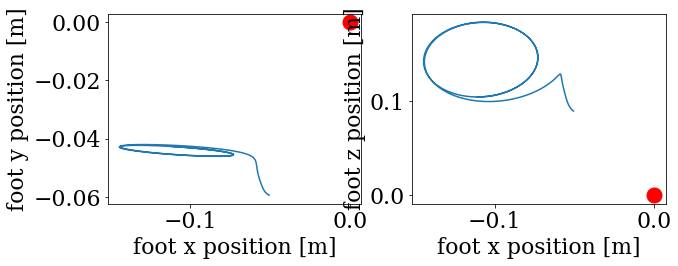

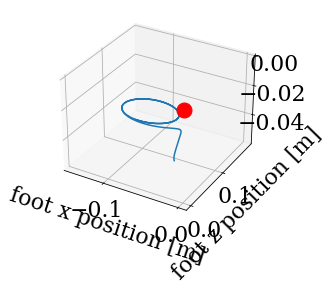

In [25]:
l0 = 0.3
l1 = 0.16
l2 = 0.16
l3 = 0.014

def plot_foot_trajectory(x_pos, y_pos, z_pos):
    """
    plots the position of the foot in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """    
    fig = plt.figure(figsize=(10,3.5))
    plt.subplot(1,2,1)
    plt.plot(x_pos,y_pos)
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot y position [m]')
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    plt.subplot(1,2,2)
    plt.plot(x_pos,z_pos)
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot z position [m]')
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot3D(x_pos,z_pos,y_pos)
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot z position [m]')
    ax.plot3D([0],[0],[0],'o',markersize=15,color='r')
    
plot_foot_trajectory(x_pos, y_pos, z_pos)

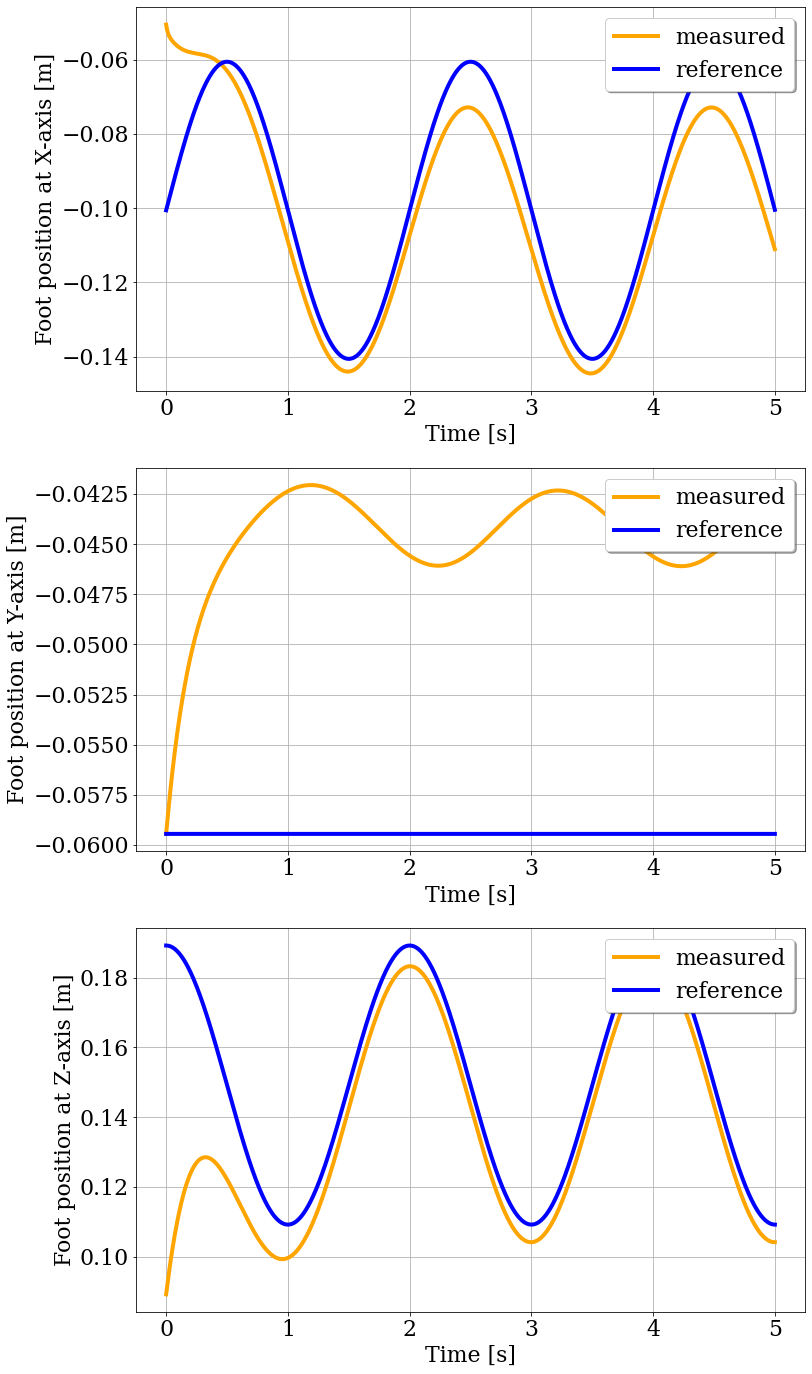

In [26]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

def plot_foot_positions(t, measured_foot_positions, desired_foot_positions):
    fig, ax = plt.subplots(3, 1, figsize=(12, 8*3))
    labels = ['X', 'Y', 'Z']

    for i in range(3):
        ax[i].plot(simulation_time, measured_foot_positions[:, i], 
                   lw=4, color='orange',
                   label='measured')
        ax[i].plot(simulation_time, desired_foot_positions[:, i], 
                   lw=4, color='blue',
                   label='reference')

        ax[i].grid()
        ax[i].set_xlabel('Time [s]')
        ax[i].set_ylabel(f'Foot position at {labels[i]}-axis [m]' )
        _ = ax[i].legend(loc='upper right', ncol=1, fancybox=True, shadow=True)
        
measured_foot_positions = np.vstack((x_pos, y_pos, z_pos)).T
plot_foot_positions(simulation_time, measured_foot_positions, reference_foot_positions)


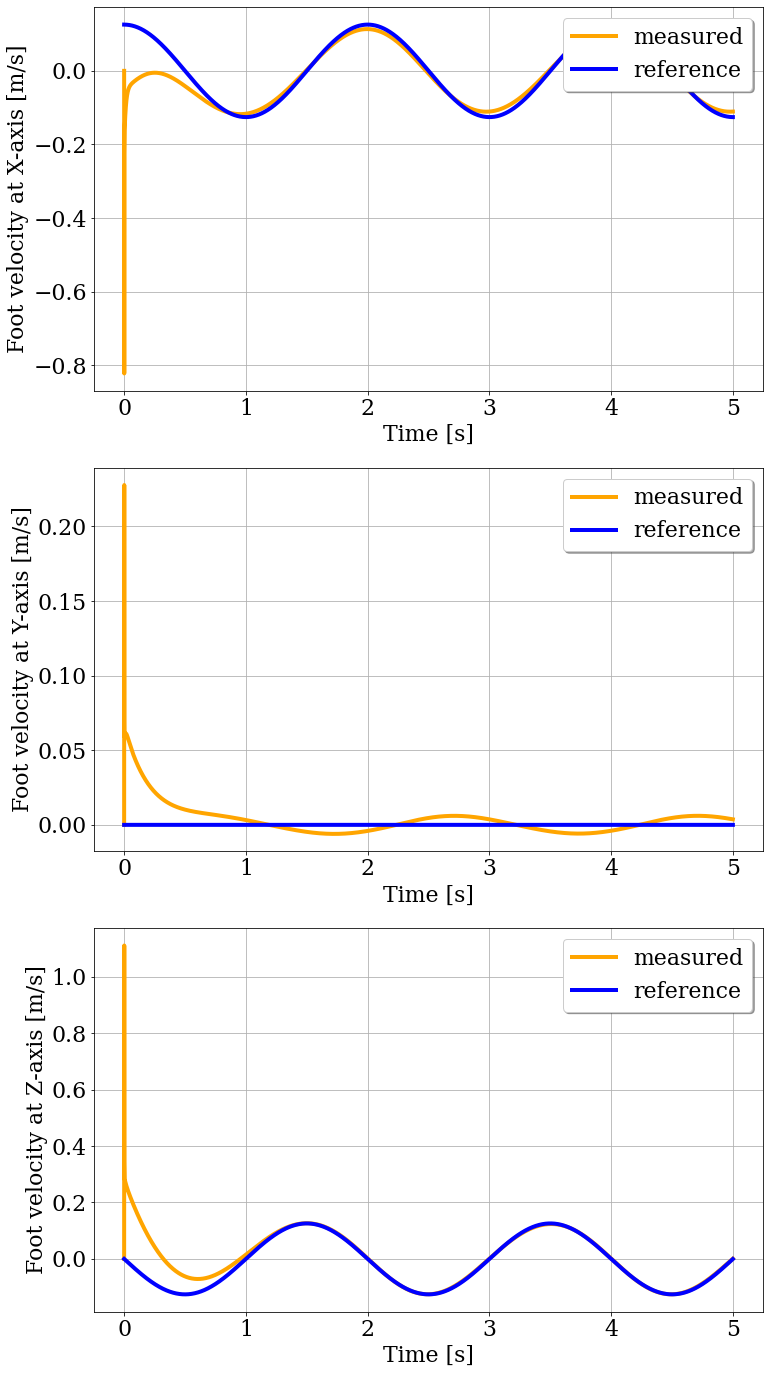

In [21]:
def plot_foot_velocities(t, measured_foot_velocities, desired_foot_velocities):
    fig, ax = plt.subplots(3, 1, figsize=(12, 8*3))
    labels = ['X', 'Y', 'Z']

    for i in range(3):
        ax[i].plot(simulation_time, measured_foot_velocities[:, i], 
                   lw=4, color='orange',
                   label='measured')
        ax[i].plot(simulation_time, desired_foot_velocities[:, i], 
                   lw=4, color='blue',
                   label='reference')

        ax[i].grid()
        ax[i].set_xlabel('Time [s]')
        ax[i].set_ylabel(f'Foot velocity at {labels[i]}-axis [m/s]' )
        _ = ax[i].legend(loc='upper right', ncol=1, fancybox=True, shadow=True)

measured_foot_velocities = np.vstack((x_vel, y_vel, z_vel)).T
plot_foot_velocities(simulation_time, measured_foot_velocities, reference_foot_velocities)